In [122]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx


import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import KBinsDiscretizer
import plotly.express as px

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster,HeatMap,HeatMapWithTime
import branca.colormap as colormap
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import geopandas as gpd
from shapely.geometry import Point

# GNN Model

In [123]:
json_file_path = "Countries/nodes_and_links_countries.json"

with open(json_file_path, 'r') as j:
     jdict = json.loads(j.read())
     
path = "Countries/countries of the world.csv"
df_gdp = pd.read_csv(path,decimal=',')

In [124]:
df_gdp['Country'] = df_gdp['Country'].map(lambda x: str(x)[:-1])

correspondence = {
   'Micronesia, Fed. St.':'Federated States of Micronesia',
   'Antigua & Barbuda':'Antigua and Barbuda',
   'Bahamas, The':'Bahamas',
   'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
   'Trinidad & Tobago':'Trinidad and Tobago',
   'Central African Rep.': 'Central African Republic',
   'Congo, Dem. Rep.':'Democratic Republic of the Congo',
   'Congo, Repub. of the':'Republic of the Congo',
   "Cote d'Ivoire": "Côte d'Ivoire",
   'Gambia, The': 'The Gambia',
   'Sao Tome & Principe':'São Tomé and Príncipe',
   'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
   'Macedonia':'North Macedonia',
   'China': "People's Republic of China",
   'Korea, North':'North Korea',
   'Korea, South':'South Korea',
   'Burma':'Myanmar'
    }

df_gdp = df_gdp.replace({"Country": correspondence})

countries_df = df_gdp['Country'].values
countries_nodes = ([node['name'] for node in jdict['nodes']])

mismatch = [i for i in countries_nodes if i not in countries_df]
nodes = set(countries_nodes)-set(mismatch)
nodes_df = [i for i in nodes]

df = df_gdp[df_gdp['Country'].isin(nodes_df)]

df.drop(['Region'], axis=1, inplace=True)

c:\Users\samuel.nporto\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [125]:
df_filtered = df.copy()
df_filtered['Infant mortality (per 1000 births)'] = df['Infant mortality (per 1000 births)'].apply(np.log10)
df_filtered['GDP ($ per capita)'] = df['GDP ($ per capita)'].apply(np.log10)
df_filtered['Phones (per 1000)'] = df['Phones (per 1000)'].apply(np.log10)
df_filtered['Pop. Density (per sq. mi.)'] = df['Pop. Density (per sq. mi.)'].apply(np.log10)
df_filtered['Other (%)'] = df['Other (%)'].apply(np.sqrt)
df_filtered['Literacy (%)'] = df['Literacy (%)'].apply(np.sqrt)

In [126]:
df_test = df_filtered.copy()

class_values = sorted(df_test["Country"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}

df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])

df_test=df_test.dropna()

df_test['GDP'] =df_test['GDP ($ per capita)']

df_test.drop(['GDP ($ per capita)'], axis=1, inplace=True)

In [127]:
existing_countries = df_test.Country.to_list()

edges = []
for n in jdict['links']:
    if (n['source'] in existing_countries) and (n['target'] in existing_countries):
        edges.append((n['source'], n['target']))
        
df_edges= pd.DataFrame.from_records(edges, columns =['source', 'target'])

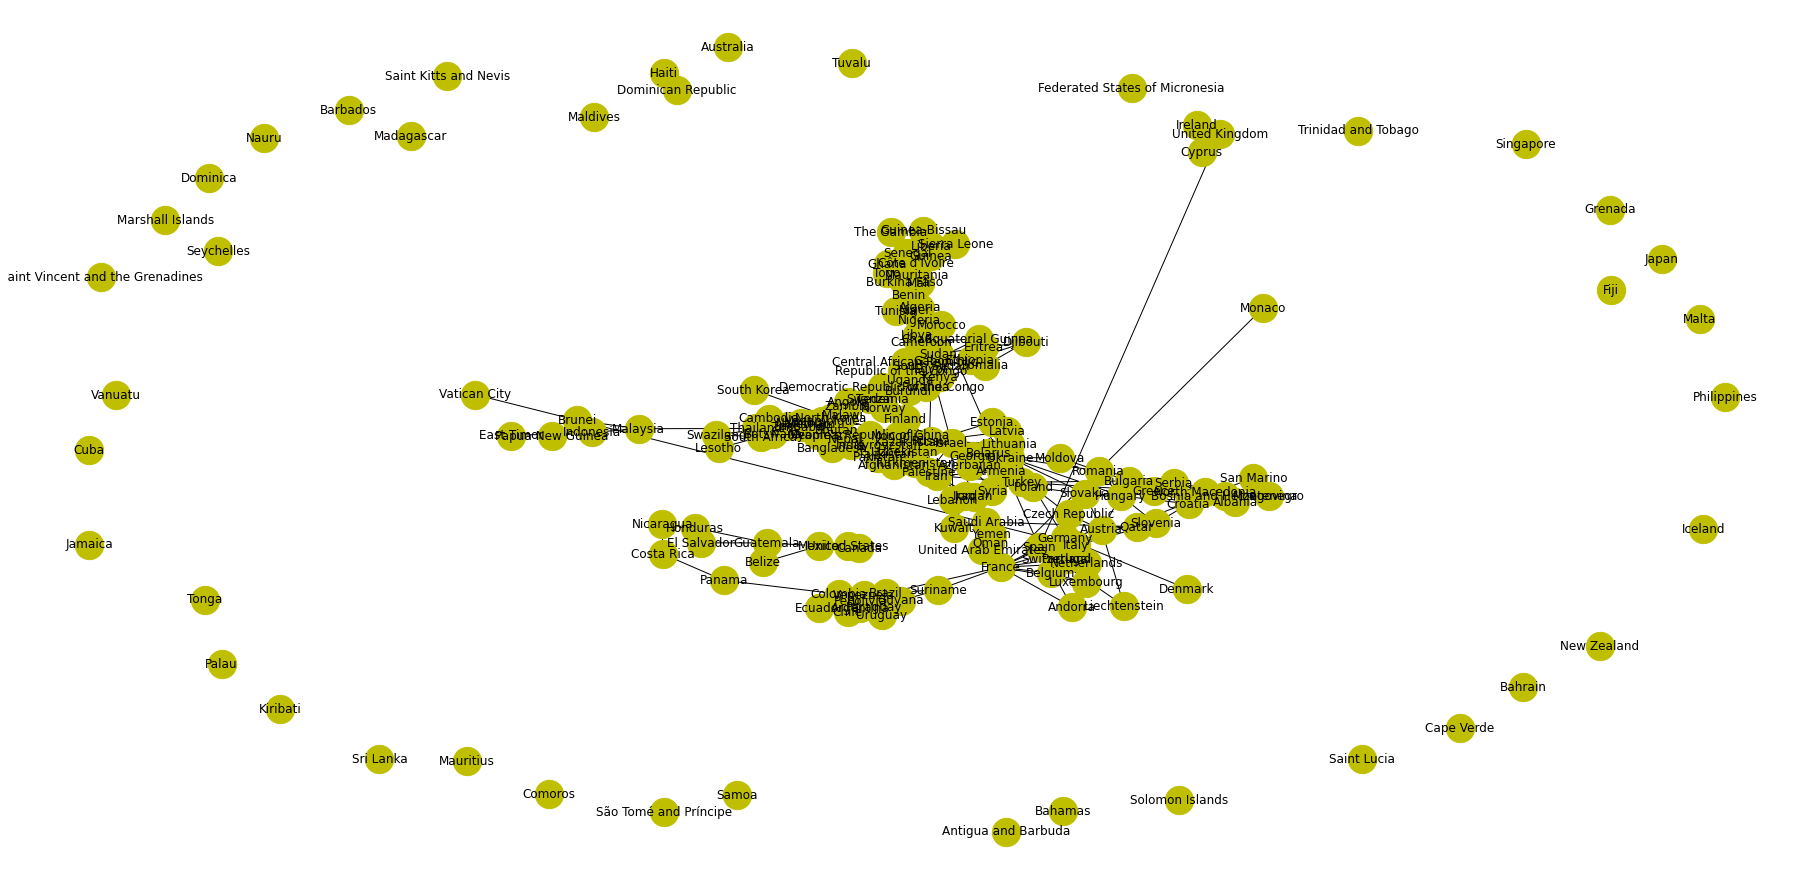

In [128]:
G = nx.Graph()
G.add_nodes_from([node['name'] for node in jdict['nodes']])
G.add_weighted_edges_from([(edge['source'], edge['target'], edge['border'])
                  for edge in jdict['links']])

pos = nx.spring_layout(G, k=.6)
plt.figure(figsize=(25,12))
nx.draw(G, 
        pos=pos,
        node_size=800, 
        with_labels=True, 
        node_color='y')
plt.show()

In [129]:
class_values = sorted(df_test["Country"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}

df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])

df_edges["source"] = df_edges["source"].apply(lambda name: class_idx[name])
df_edges["target"] = df_edges["target"].apply(lambda name: class_idx[name])

In [130]:
feature_names = set(df_test.columns) - {"Country", "GDP", 'Country ID'}
num_features = len(feature_names)
num_classes = num_features

In [131]:
train_data, test_data = [], []

for _, group_data in df_test.groupby("GDP"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

y_train = train_data["GDP"]
y_test = test_data["GDP"]

In [132]:
DROPOUT_RATE  =0.2

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(1e-1),
        loss='mse',
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="loss", patience=50, restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=5000,
        batch_size=2048,
        validation_split=0.2,
        callbacks=[early_stopping],

    )

    return history

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=DROPOUT_RATE,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]
        aggregated_message = tf.math.unsorted_segment_mean(
            neighbour_messages, node_indices, num_segments=num_nodes
        )
        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        node_embeddings = self.update_fn(h)
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        return self.update(node_repesentations, aggregated_messages)

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=DROPOUT_RATE,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

In [133]:
edges = df_edges[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    df_test.sort_values("Country")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

graph_info = (node_features, edges, edge_weights)

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[32, 32],
    dropout_rate=DROPOUT_RATE,
    name="gnn_model",
)

In [134]:
gnn_model([1,10])

<tf.Tensor: shape=(2, 17), dtype=float32, numpy=
array([[  34769.492 ,   62991.516 ,  -57415.223 , -185094.42  ,
        -125442.58  ,   12925.176 ,  -51835.168 ,  -31670.05  ,
        -150002.06  ,    5297.371 ,  -25579.023 ,   59016.953 ,
          64115.77  ,  -54043.164 ,   40221.53  ,   84810.53  ,
         -43789.03  ],
       [   7172.1226,   12363.1875,  -10942.549 ,  -37304.78  ,
         -25440.934 ,    2280.7034,  -10171.876 ,   -6732.128 ,
         -29481.387 ,    1395.1318,   -4368.0605,   11688.661 ,
          12742.619 ,  -11095.136 ,    7620.886 ,   16597.926 ,
          -8398.096 ]], dtype=float32)>

In [135]:
x_train = train_data['Country ID'].to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/5000
1/1 [==============================] - 5s 5s/step - loss: 14.9652 - val_loss: 10.6739
Epoch 2/5000
1/1 [==============================] - 0s 47ms/step - loss: 7.3697 - val_loss: 266.6904
Epoch 3/5000
1/1 [==============================] - 0s 36ms/step - loss: 7.3640 - val_loss: 2769.0715
Epoch 4/5000
1/1 [==============================] - 0s 39ms/step - loss: 5.7127 - val_loss: 1765.8174
Epoch 5/5000
1/1 [==============================] - 0s 42ms/step - loss: 2.6337 - val_loss: 844.6832
Epoch 6/5000
1/1 [==============================] - 0s 43ms/step - loss: 2.0499 - val_loss: 680.0441
Epoch 7/5000
1/1 [==============================] - 0s 36ms/step - loss: 1.8164 - val_loss: 937.7404
Epoch 8/5000
1/1 [==============================] - 0s 37ms/step - loss: 1.6540 - val_loss: 829.3773
Epoch 9/5000
1/1 [==============================] - 0s 42ms/step - loss: 1.1716 - val_loss: 907.5625
Epoch 10/5000
1/1 [==============================] - 0s 36ms/step - loss: 0.9515 - val_loss

In [136]:
x_test = test_data['Country ID'].to_numpy()

mse_train = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
mse_test = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)

print(np.sqrt(mse_train), np.sqrt(mse_test))

0.21486868280175422 0.1986939586496837


In [137]:
test_data.head()

,Country,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Country ID,GDP
61,El Salvador,6822378,21040,2.510947,1.46,-3.74,1.399674,8.955445,2.153510,31.85,12.07,7.488658,2.0,26.61,5.78,0.099,0.302,0.599,44,3.681241
37,Cape Verde,420979,4033,2.018700,23.93,-12.07,1.679155,8.752143,2.229426,9.68,0.50,9.477341,3.0,24.87,6.55,0.121,0.219,0.660,27,3.146128
86,Guinea,9690222,245857,1.595496,0.13,-3.06,1.956024,5.991661,0.431364,3.63,2.58,9.684524,2.0,41.76,15.48,0.237,0.362,0.401,60,3.322219
64,Estonia,1324333,45226,1.466868,8.39,-3.16,0.895975,9.989995,2.523486,16.04,0.45,9.138381,3.0,10.04,13.25,0.040,0.294,0.666,47,4.089905
105,Jordan,5906760,92300,1.806180,0.03,6.59,1.239299,9.555103,2.019116,2.67,1.83,9.772410,1.0,21.25,2.65,0.033,0.287,0.680,75,3.633468


In [138]:
predictions = pd.DataFrame(list(zip(x_test, gnn_model(x_test).numpy()[:,0], y_test))).rename(columns = {0 : "Country ID", 1: "GDP Prediction", 2: "Real GDP"})

gnn_predictions_test = predictions.merge(test_data[["Country", "Country ID"]], on = "Country ID", how = "left")

gnn_predictions_test

,Country ID,GDP Prediction,Real GDP,Country
0,44,3.558879,3.681241,El Salvador
1,27,3.398412,3.146128,Cape Verde
2,60,2.812779,3.322219,Guinea
3,47,4.265089,4.089905,Estonia
4,75,3.944459,3.633468,Jordan
...,...,...,...,...
57,145,3.223520,3.342423,Tonga
58,114,4.062626,4.045323,Poland
59,32,2.927216,2.845098,Comoros
60,85,2.842040,2.903090,Madagascar


In [139]:
predictions = pd.DataFrame(list(zip(x_train, gnn_model(x_train).numpy()[:,0], y_train))).rename(columns = {0 : "Country ID", 1: "GDP Prediction", 2: "Real GDP"})

gnn_predictions_train = predictions.merge(train_data[["Country", "Country ID"]], on = "Country ID", how = "left")

gnn_predictions_train

,Country ID,GDP Prediction,Real GDP,Country
0,78,4.224298,4.278754,Kuwait
1,130,3.759334,4.029384,South Africa
2,143,2.930889,3.230449,The Gambia
3,144,2.921186,3.176091,Togo
4,53,3.047297,3.740363,Gabon
...,...,...,...,...
96,103,3.480018,3.113943,North Korea
97,121,3.814024,3.732394,Saint Lucia
98,138,4.505600,4.514548,Switzerland
99,98,4.331991,4.456366,Netherlands


In [140]:
gnn_predictions = gnn_predictions_train.append(gnn_predictions_test)

gnn_predictions

,Country ID,GDP Prediction,Real GDP,Country
0,78,4.224298,4.278754,Kuwait
1,130,3.759334,4.029384,South Africa
2,143,2.930889,3.230449,The Gambia
3,144,2.921186,3.176091,Togo
4,53,3.047297,3.740363,Gabon
...,...,...,...,...
57,145,3.223520,3.342423,Tonga
58,114,4.062626,4.045323,Poland
59,32,2.927216,2.845098,Comoros
60,85,2.842040,2.903090,Madagascar


# RNN

In [141]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

RANDOM_SEED = 42
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [142]:
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)


In [143]:
df_latlong = pd.read_csv('countries.csv')
df_latlong.drop(['Importance', 'Altitude'], axis=1, inplace=True)

df_gdp = pd.read_csv('gdp_per_capita.csv')
df_gdp.drop(['Unnamed: 65', 'Code'], axis=1, inplace=True)

countries_df_latlong = df_latlong['Country'].values
countries_df_gdp = df_gdp['Country Name'].values

mismatch = [i for i in countries_df_latlong if i not in countries_df_gdp]

nodes = set(countries_df_latlong)-set(mismatch)
nodes_df = [i for i in nodes]

df = df_latlong[df_latlong['Country'].isin(nodes_df)]

df = pd.merge(df_latlong,df_gdp,how='inner',left_on=['Country'],right_on=['Country Name'])

df.drop(['Country Name'], axis=1, inplace=True)

df = df.rename({'Latitude': 'Lat', 'Longitude': 'Lon'}, axis=1)

GDP_years = list(set(df.columns) - {'Country', 'Lat', 'Lon'})

for column in GDP_years:
    df[column] = np.log10(df[column])

df = df.melt(id_vars=['Country', 'Lat', 'Lon'], 
        var_name="Year", 
        value_name="GDP")

data = df.copy()

In [144]:
lista_unica = unique(df['Country'].tolist())       

dataset = []
for pais in lista_unica:
   data_pais = df[df["Country"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   linha = 0
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
 
   while linha<len(gdp)-3: 
    #  dataset_array = []
    
     gdp_1 = gdp[linha]
     gdp_2 = gdp[linha+1]
     gdp_3 = gdp[linha+2]
     gdp_4 = gdp[linha+3]
     gdp_5 = gdp[linha+4]

    #  print("gdp_1 {0}".format(gdp_1))
    #  print("gdp_2 {0}".format(gdp_2))
    #  print("gdp_3 {0}".format(gdp_3))
    #  print("gdp_4 {0}".format(gdp_4))
    #  print("gdp_5 {0}".format(gdp_5))
     if math.isnan(gdp_1) or math.isnan(gdp_2) or math.isnan(gdp_3) or math.isnan(gdp_4) or math.isnan(gdp_5):
       nan = 0
      #  print(gdp_1[0])
      #  print("nan")
     else:
       dataset.append([latitude_pais, longitude_pais, gdp_1, gdp_2, gdp_3, gdp_4, gdp_5])

      
      # dataset.append(dataset_array)
     linha +=4

my_array = np.array(dataset)
dataset = my_array.astype('float32')
# Normalizando os Valores
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

n_steps = 6 #CADA LISTA DENTRO DA LISTA VAI TER 7 DADOS

setenta_porc= int((70*len(dataset))/100)
vint_poc = int((20*len(dataset))/100)
nov_porc=setenta_porc+vint_poc

X_train, y_train = dataset[:setenta_porc, :n_steps], dataset[:setenta_porc, -1]
X_valid, y_valid = dataset[setenta_porc:nov_porc, :n_steps], dataset[setenta_porc:nov_porc, -1]
X_test, y_test = dataset[nov_porc:, :n_steps], dataset[nov_porc:, -1]

y_pred = X_valid[:, -1]

model = keras.models.Sequential([
    # keras.layers.Flatten(input_shape=[6, 1]),
    keras.layers.Dense(1,input_shape=[6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=128, #128
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
11/11 [==============================] - 1s 30ms/step - loss: 1.0863 - val_loss: 0.6307
Epoch 2/80
11/11 [==============================] - 0s 8ms/step - loss: 0.4104 - val_loss: 0.1794
Epoch 3/80
11/11 [==============================] - 0s 8ms/step - loss: 0.1077 - val_loss: 0.0406
Epoch 4/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0323 - val_loss: 0.0328
Epoch 5/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0302 - val_loss: 0.0358
Epoch 6/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0292 - val_loss: 0.0306
Epoch 7/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0249 - val_loss: 0.0254
Epoch 8/80
11/11 [==============================] - 0s 10ms/step - loss: 0.0225 - val_loss: 0.0229
Epoch 9/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0208 - val_loss: 0.0212
Epoch 10/80
11/11 [==============================] - 0s 10ms/step - loss: 0.0193 - val_loss: 0.0196
Epoch 11/80
11/1

In [145]:
X_train.shape, y_train.shape

((1332, 6), (1332,))

In [146]:
y_pred = X_valid[:, -1]

model = keras.models.Sequential([
    # keras.layers.Flatten(input_shape=[6, 1]),
    keras.layers.Dense(1,input_shape=[6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=128, #128
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
11/11 [==============================] - 1s 29ms/step - loss: 0.9282 - val_loss: 0.5856
Epoch 2/80
11/11 [==============================] - 0s 9ms/step - loss: 0.3516 - val_loss: 0.1956
Epoch 3/80
11/11 [==============================] - 0s 9ms/step - loss: 0.1285 - val_loss: 0.0939
Epoch 4/80
11/11 [==============================] - 0s 9ms/step - loss: 0.0919 - val_loss: 0.0875
Epoch 5/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0906 - val_loss: 0.0813
Epoch 6/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0820 - val_loss: 0.0736
Epoch 7/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0735 - val_loss: 0.0684
Epoch 8/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0678 - val_loss: 0.0633
Epoch 9/80
11/11 [==============================] - 0s 9ms/step - loss: 0.0622 - val_loss: 0.0570
Epoch 10/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0565 - val_loss: 0.0514
Epoch 11/80
11/11 

In [147]:
model.evaluate(X_valid, y_valid)

12/12 [==============================] - 0s 2ms/step - loss: 7.9736e-04


0.0007973557221703231

In [148]:
model.layers[0].get_weights()

[array([[ 0.02367588],
        [ 0.00733024],
        [ 0.02702561],
        [ 0.70303786],
        [-0.12107781],
        [ 0.3604534 ]], dtype=float32),
 array([0.01847213], dtype=float32)]

In [149]:
y_pred = model.predict(X_valid)

12/12 [==============================] - 0s 2ms/step


In [150]:
X_train = X_train.reshape((1332,1,6))
X_valid = X_valid.reshape((380,1,6))

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=20, #20
    batch_size=180, #180
    validation_data=(X_valid, y_valid),
)

y_pred = model.predict(X_valid)

X_valid = X_valid.reshape((380, 6))

Epoch 1/20
8/8 [==============================] - 2s 71ms/step - loss: 0.3232 - val_loss: 0.1506
Epoch 2/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0837 - val_loss: 0.0244
Epoch 3/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0124 - val_loss: 0.0054
Epoch 4/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0083
Epoch 5/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0088 - val_loss: 0.0096
Epoch 6/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 7/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 8/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 9/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 10/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 11/20
8/8 [============

In [151]:
X_train = X_train.reshape((1332,1,6))
X_valid = X_valid.reshape((380,1,6))

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=180, #180
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
8/8 [==============================] - 2s 67ms/step - loss: 1.6596 - val_loss: 1.6022
Epoch 2/80
8/8 [==============================] - 0s 9ms/step - loss: 1.3477 - val_loss: 1.2286
Epoch 3/80
8/8 [==============================] - 0s 8ms/step - loss: 0.9319 - val_loss: 0.7496
Epoch 4/80
8/8 [==============================] - 0s 10ms/step - loss: 0.4873 - val_loss: 0.3168
Epoch 5/80
8/8 [==============================] - 0s 12ms/step - loss: 0.1807 - val_loss: 0.1042
Epoch 6/80
8/8 [==============================] - 0s 11ms/step - loss: 0.0708 - val_loss: 0.0507
Epoch 7/80
8/8 [==============================] - 0s 12ms/step - loss: 0.0532 - val_loss: 0.0441
Epoch 8/80
8/8 [==============================] - 0s 12ms/step - loss: 0.0529 - val_loss: 0.0441
Epoch 9/80
8/8 [==============================] - 0s 11ms/step - loss: 0.0534 - val_loss: 0.0432
Epoch 10/80
8/8 [==============================] - 0s 11ms/step - loss: 0.0519 - val_loss: 0.0416
Epoch 11/80
8/8 [==============

In [152]:
y_pred = model.predict(X_valid)

X_valid = X_valid.reshape((380, 6))

12/12 [==============================] - 0s 3ms/step


In [153]:
X_test = X_test.reshape((192,1,6))

y_pred = model.predict(X_test)

X_test = X_test.reshape((192, 6))


6/6 [==============================] - 0s 3ms/step


## RNN 2016

In [154]:
lista_unica = unique(df['Country'].tolist())

dataset_2016 = []
pais_lista=[]
maximo=0
for pais in lista_unica:
   data_pais = df[df["Country"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
   gdp_1 = gdp[52]
   gdp_2 = gdp[53]
   gdp_3 = gdp[54]
   gdp_4 = gdp[55]
   gdp_5 = gdp[56]
   if math.isnan(gdp_1) or math.isnan(gdp_2) or math.isnan(gdp_3) or math.isnan(gdp_4) or math.isnan(gdp_5):
     nan = 0
      #  print(gdp_1[0])
      #  print("nan")
   else:
      if maximo < gdp_1 or maximo < gdp_2 or maximo < gdp_3 or maximo < gdp_4 or maximo < gdp_5:
        maximo = max(gdp_1,gdp_2,gdp_3,gdp_4,gdp_5)
      dataset_2016.append([latitude_pais, longitude_pais, gdp_1, gdp_2, gdp_3, gdp_4, gdp_5])
      pais_lista.append(pais)
      
      # dataset.append(dataset_array)

# print(dataset_2016)    


In [155]:
my_array = np.array(dataset_2016)
dataset_2016 = my_array.astype('float32')
# Normalizando os Valores
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_2016 = scaler.fit_transform(dataset_2016)

In [156]:
n_steps = 6
X_2016, y_2016 = dataset_2016[:, :n_steps], dataset_2016[:, -1]

In [157]:
y_2016.shape

(156,)

In [158]:
X_2016.shape

(156, 6)

In [159]:
X_2016 = X_2016.reshape((156,1,6))

In [160]:
print(model.evaluate(X_2016, y_2016))

5/5 [==============================] - 0s 4ms/step - loss: 0.0032
0.003183664521202445


5/5 [==============================] - 0s 4ms/step


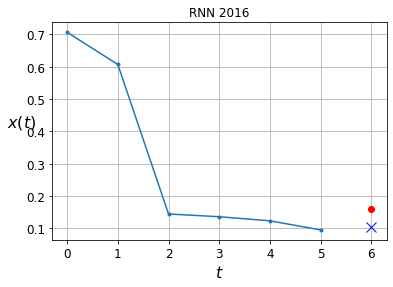

In [161]:
y_pred = model.predict(X_2016)

X_2016 = X_2016.reshape((156, 6))
plot_series(X_2016[0, :], y_2016[0], y_pred[0])
plt.title("RNN 2016")
plt.show()

In [162]:
print(y_2016)
y_2016_pred = y_pred.reshape(156)
# y_2016_pred=[]
# for y in y_pred

[0.10422927 0.42613715 0.41934484 0.7666554  0.40108806 0.6274026
 0.60078126 0.40481657 0.81077975 0.79583424 0.41675395 0.68867713
 0.25960892 0.64377457 0.4570753  0.7841839  0.45137733 0.2204315
 0.3734222  0.38092822 0.45570034 0.5073963  0.5414985  0.51984173
 0.14987189 0.         0.38362974 0.24434954 0.26089066 0.78539747
 0.06697798 0.1510331  0.6119862  0.5301866  0.4806283  0.5910849
 0.31550056 0.59758145 0.5295455  0.7017407  0.82490593 0.36650866
 0.529931   0.5138437  0.48552555 0.4137531  0.55078405 0.65591043
 0.39750212 0.1562131  0.47474843 0.790662   0.7648403  0.5074294
 0.4238041  0.7846368  0.31229275 0.652746   0.556963   0.4279688
 0.15944248 0.14374512 0.47905964 0.24685568 0.33779103 0.60456055
 0.84430665 0.29232174 0.40356523 0.4413256  0.8463617  0.76605564
 0.7370836  0.45095664 0.7743848  0.42804474 0.5227768  0.27265638
 0.41185898 0.7197556  0.61823505 0.52154976 0.16124886 0.42277616
 0.9959672  0.6253523  0.92828757 0.09296143 0.02965438 0.5599709
 

In [163]:
data = {'Pais': pais_lista ,
        '2016':[(item * maximo) for item in y_2016] ,
         '2016 predição':[(item * maximo) for item in y_2016_pred],
        }

df = pd.DataFrame(data)
df

,Pais,2016,2016 predição
0,Afghanistan,0.550065,0.848895
1,Albania,2.248919,2.593053
2,Algeria,2.213073,2.706829
3,Andorra,4.045989,3.868648
4,Angola,2.116724,2.522438
...,...,...,...
151,Uzbekistan,1.905398,2.106189
152,Vietnam,1.734320,1.696775
153,West Bank and Gaza,2.121711,2.310263
154,Zambia,1.296705,1.620691


In [164]:
gnn_predictions

,Country ID,GDP Prediction,Real GDP,Country
0,78,4.224298,4.278754,Kuwait
1,130,3.759334,4.029384,South Africa
2,143,2.930889,3.230449,The Gambia
3,144,2.921186,3.176091,Togo
4,53,3.047297,3.740363,Gabon
...,...,...,...,...
57,145,3.223520,3.342423,Tonga
58,114,4.062626,4.045323,Poland
59,32,2.927216,2.845098,Comoros
60,85,2.842040,2.903090,Madagascar


# MERGE MODELS

In [165]:
stacked_base = gnn_predictions[['Country','GDP Prediction','Real GDP']].merge(df[['Pais','2016 predição']], left_on='Country',right_on = "Pais", how='inner')

stacked_base

,Country,GDP Prediction,Real GDP,Pais,2016 predição
0,Kuwait,4.224298,4.278754,Kuwait,3.830645
1,South Africa,3.759334,4.029384,South Africa,2.667231
2,Togo,2.921186,3.176091,Togo,0.883917
3,Gabon,3.047297,3.740363,Gabon,2.970956
4,Ecuador,3.656431,3.518514,Ecuador,2.832276
...,...,...,...,...,...
121,Liechtenstein,4.418518,4.397940,Liechtenstein,4.386143
122,Costa Rica,4.035008,3.959041,Costa Rica,3.216455
123,Antigua and Barbuda,3.959958,4.041393,Antigua and Barbuda,3.338679
124,Poland,4.062626,4.045323,Poland,3.347811


In [166]:
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor

In [167]:

x_train, x_test, y_train, y_test = train_test_split(
    stacked_base.drop(['Country','Pais','Real GDP'], axis=1),
    stacked_base['Real GDP'],
    test_size = 0.2,
    random_state=RANDOM_SEED,
)

In [168]:
rfc_clf = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=150)
rfc_clf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

In [169]:
tr = cross_val_score(rfc_clf, x_train, y_train, cv=3, scoring='neg_mean_squared_error')
tst = cross_val_score(rfc_clf, x_test, y_test, cv=3, scoring='neg_mean_squared_error')

In [170]:
print(f"Model mse on train: {-1*tr.mean()}\nModel mse on test: {-1*tst.mean()}")

Model mse on train: 0.025966834412453954
Model mse on test: 0.018790662825026092


In [171]:
from sklearn.metrics import mean_squared_error

rfc_clf.fit(x_train, y_train)

y_pred = rfc_clf.predict(x_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 0.14
